In [3]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2 as cv

In [4]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('.\\DATASET\\'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'Blank': 0, 'X Rotation': 1, 'Y Rotation': 2}

In [5]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for j in os.listdir('.\\DATASET\\'):
    if not j.startswith('.'):
        count = 0 # To tally images of a given gesture
        for k in os.listdir('.\\DATASET\\' + j+'\\'):
            img = Image.open('.\\DATASET\\' + j + '\\' + k).convert('RGB')
            img = img.resize((224, 224))
            arr = np.array(img)
            x_data.append(arr) 
            count = count + 1
        y_values = np.full((count, 1), lookup[j]) 
        y_data.append(y_values)
        datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
print(y_data.shape)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size
print("Y data:")
print(y_data.shape)
print("X data:")
print(x_data.shape)

(3, 500, 1)
Y data:
(1500, 1)
X data:
(1500, 224, 224, 3)


In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.2)
print(x_train.shape)
print(y_train.shape)

(1200, 224, 224, 3)
(1200, 1)


In [7]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255., 
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow(x_train,y_train, batch_size = 20)

validation_generator = test_datagen.flow(x_test,y_test, batch_size = 20)


j=train_generator.next()
print("X train: ")
print(j[0].shape)
print("Y train: ")
print(j[1].shape)

X train: 
(20, 224, 224, 3)
Y train: 
(20, 1)


In [10]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2((224,224,3),
                         include_top= False,
                         weights='imagenet')

9420800/9406464 [==============================] - 6s 1us/step


In [11]:
base_model.trainable = False

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense

global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(1)

In [14]:
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=RMSprop(learning_rate=base_learning_rate),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
validation_steps=None
initial_epochs = 20

loss0,accuracy0 = model.evaluate(validation_generator,
                                 steps = validation_steps)

15/15 [==============================] - 7s 461ms/step - loss: 0.3791 - accuracy: 0.4767


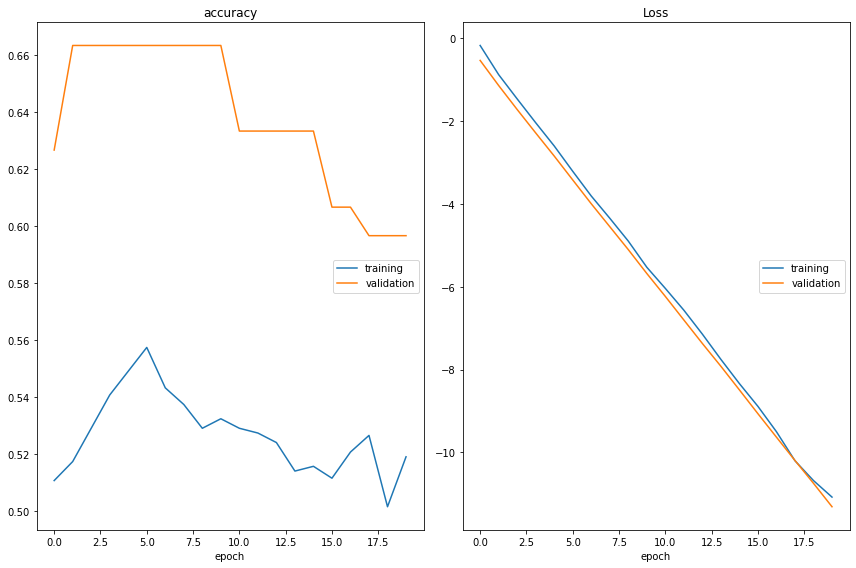

accuracy
	training         	 (min:    0.502, max:    0.558, cur:    0.519)
	validation       	 (min:    0.597, max:    0.663, cur:    0.597)
Loss
	training         	 (min:  -11.080, max:   -0.175, cur:  -11.080)
	validation       	 (min:  -11.313, max:   -0.536, cur:  -11.313)
60/60 [==============================] - 40s 671ms/step - loss: -11.0804 - accuracy: 0.5192 - val_loss: -11.3132 - val_accuracy: 0.5967


In [17]:
from livelossplot import PlotLossesKeras

history = model.fit(train_generator,
                    epochs=initial_epochs,
                    callbacks=[PlotLossesKeras()],
                    validation_data=validation_generator)

In [18]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


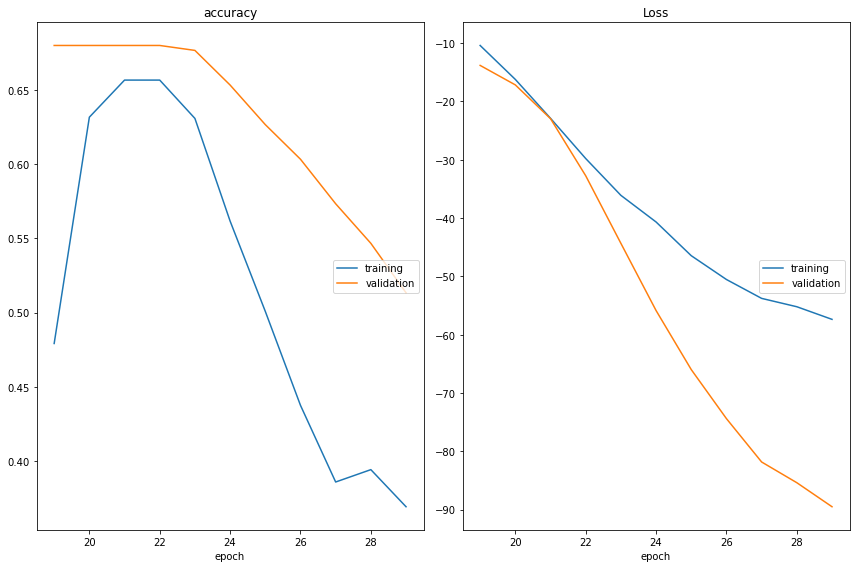

accuracy
	training         	 (min:    0.369, max:    0.657, cur:    0.369)
	validation       	 (min:    0.513, max:    0.680, cur:    0.513)
Loss
	training         	 (min:  -57.368, max:  -10.389, cur:  -57.368)
	validation       	 (min:  -89.508, max:  -13.811, cur:  -89.508)
60/60 [==============================] - 53s 889ms/step - loss: -57.3678 - accuracy: 0.3692 - val_loss: -89.5078 - val_accuracy: 0.5133


In [20]:
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer = RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         callbacks=[PlotLossesKeras()],
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_generator)